<a href="https://colab.research.google.com/github/Kusakawama/MADS_CNN/blob/main/ConceptSHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 883.4 kB/s eta 0:00:00


In [2]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from keras.models import Model
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from tensorflow_datasets.core import lazy_builder_import

## Data Loading

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle-2.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle-2.json': No such file or directory
ref                                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                         Student Performance Predictions                      9KB  2024-08-17 06:57:57           2966         71  0.9411765        
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                           1KB  2024-08-14 11:02:45           3091         56  1.0              
haseebindata/global-population-growth-2024                           Global Population Growth 2024                      

In [4]:
! kaggle datasets download abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
100% 1.44G/1.45G [00:13<00:00, 124MB/s]
100% 1.45G/1.45G [00:13<00:00, 118MB/s]


In [5]:
  ! unzip wildfire-prediction-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: valid/nowildfire/-73.481565,45.467244.jpg  
  inflating: valid/nowildfire/-73.483407,45.637554.jpg  
  inflating: valid/nowildfire/-73.48589

In [6]:
! kaggle datasets download apollo2506/landuse-scene-classification

Dataset URL: https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification
License(s): CC0-1.0
 99% 1.97G/1.98G [00:13<00:00, 137MB/s]
100% 1.98G/1.98G [00:13<00:00, 156MB/s]


In [7]:
! mkdir -p concepts
! unzip landuse-scene-classification.zip -d concepts

Streaming output truncated to the last 5000 lines.
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000365.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000366.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000367.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000368.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000369.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000371.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000372.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000374.png  
  inflating: concepts/images_train_test_val/train/mediumresidential/mediumresidential_000376.png  
  inflating: concepts/images_train_test_val/train/mediumre

In [8]:
class CustomDataGenerator(Sequence):
    def __init__(self, directory, batch_size=32, target_size=(224, 224), class_mode='categorical', shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle

        self.classes = sorted(os.listdir(directory))
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths, self.labels = self._get_image_paths_and_labels()

        self.on_epoch_end()  # Shuffle the data if necessary

    def _get_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for cls in self.classes:
            cls_dir = os.path.join(self.directory, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.startswith('.'):  # Skip hidden files
                    continue
                image_paths.append(os.path.join(cls_dir, img_name))
                labels.append(self.class_indices[cls])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        images = np.array([self._load_image_opencv(img_path) for img_path in batch_image_paths])
        labels = np.array(batch_labels)

        if self.class_mode == 'categorical':
            labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.classes))

        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)
            self.image_paths = list(self.image_paths)
            self.labels = list(self.labels)

    def _load_image_opencv(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, self.target_size)  # Resize to target size
        img = img.astype('float32') / 255.0  # Normalize the image
        return img

# Usage:
train_generator = CustomDataGenerator('/content/train', batch_size=16, target_size=(224, 224))
val_generator = CustomDataGenerator('/content/valid', batch_size=16, target_size=(224, 224))

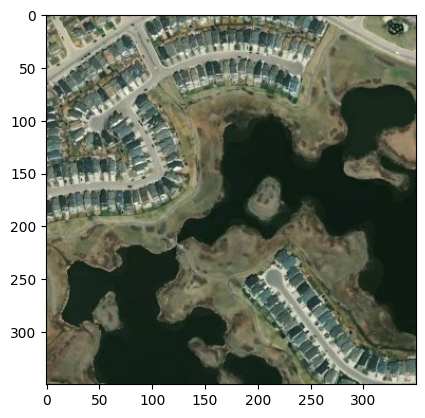

In [9]:
#test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg" #wildfire
test_img_path = "/content/test/nowildfire/-113.91777,50.901087.jpg" #nowildire
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
#plt.xlabel("Wildfire")
#plt.xlabel("No Wildfire")
plt.show()

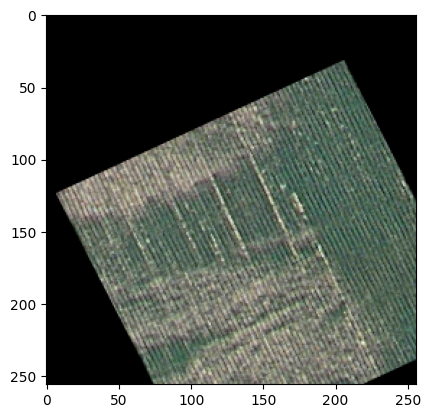

In [10]:
#test_img_path = "/content/test/wildfire/-59.03238,51.85132.jpg" #wildfire
test_img_path = "/content/concepts/images/agricultural/agricultural_000001.png" #agricultural
image = mpimg.imread(test_img_path)

# Plot the image
imgplot = plt.imshow(image)
#plt.xlabel("Wildfire")
#plt.xlabel("No Wildfire")
plt.show()

In [7]:
test_arr = []
test_image = cv2.imread(test_img_path)
test_image = cv2.resize(test_image,(224,224))
test_image = np.array(test_image)
test_image = test_image/255
test_image = test_image.reshape(1,224,224,3)
test_arr.append(test_image)

In [11]:
from tensorflow.keras.models import load_model

# Load the saved model
model2_loaded = load_model('resent50_finetuned_224.keras')

# Use the loaded model for inference or further training
#model2_loaded.evaluate(val_generator)

## Model for concept extraction

In [13]:
#module = hub.load("https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1")

In [16]:

def preprocess_image(image_file_path_concepts):
    # Load the image
    img = cv2.imread(image_file_path_concepts)
    if img is None:
        print(f"Warning: Image at path {image_file_path_concepts} could not be loaded.")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to 224x224 as expected by ResNet50
    img = img.astype('float32') / 255.0  # Normalize to [0,1]
    return img

def load_concept_images(concepts_dir, batch_size=32):
    image_file_paths = []

    # Traverse through all the subdirectories and find image files
    for root, _, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Only include valid image files
                image_file_paths.append(os.path.join(root, file))

    print(f"Found {len(image_file_paths)} images in {concepts_dir}.")

    # If no images are found, return early
    if len(image_file_paths) == 0:
        return []

    # Shuffle the image paths for randomness
    np.random.shuffle(image_file_paths)

    # Split into batches
    for i in range(0, len(image_file_paths), batch_size):
        batch_paths = image_file_paths[i:i + batch_size]
        batch_images = []
        for image_file_path_concepts in batch_paths:
            img = preprocess_image(image_file_path_concepts)
            if img is not None:
                batch_images.append(img)

        if len(batch_images) > 0:
            yield np.array(batch_images)

def extract_features(images):
    # Convert images to TensorFlow tensors before feature extraction
    images = tf.convert_to_tensor(images)

    # Extract features using the TensorFlow Hub module
    features = module(images)  # This will output the feature vectors
    return features

def extract_concepts_from_folder(concepts_dir, feature_extractor, batch_size=32):
    concept_features = []
    for image_batch in load_concept_images(concepts_dir, batch_size=batch_size):
        print(f"Processing batch of size: {image_batch.shape}")
        features = feature_extractor(image_batch)
        concept_features.append(features.numpy())  # Convert TensorFlow tensors to numpy arrays

    if len(concept_features) == 0:
        print("No concept features were extracted.")
        return np.array([])  # Return an empty array if nothing was processed

    return np.concatenate(concept_features, axis=0)

# Assuming you're working with the "train" or "test" folders under "images_train_test_val"
# Path to the extracted concept images from the Kaggle dataset
concepts_dir = "/content/concepts/images_train_test_val/train"  # Change to 'test' or 'validation' as needed

# Extract concept features from the Kaggle dataset
concept_features = extract_concepts_from_folder(concepts_dir, extract_features, batch_size=32)

print("Extracted concept features shape:", concept_features.shape)


Found 7350 images in /content/concepts/images_train_test_val/train.
Processing batch of size: (32, 224, 224, 3)


TypeError: 'AutoTrackable' object is not callable

Found 7350 images in /content/concepts/images_train_test_val/train.
Image batch shape: (32, 224, 224, 3)


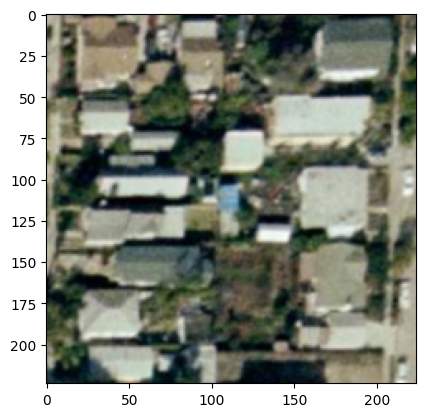

In [18]:
# Test image loading and preprocessing
concepts_dir = "/content/concepts/images_train_test_val/train"  # Adjust this path as necessary

# Load the first batch of images
image_batch = next(load_concept_images(concepts_dir, batch_size=32))

print(f"Image batch shape: {image_batch.shape}")

# Check one of the images
import matplotlib.pyplot as plt

plt.imshow(image_batch[0])
plt.show()

In [19]:
# Test feature extraction on the first image batch
try:
    features = extract_features(image_batch)
    print(f"Features shape: {features.shape}")
except Exception as e:
    print(f"Error during feature extraction: {e}")


Error during feature extraction: Exception encountered when calling FeatureExtractor.call().

'AutoTrackable' object is not callable

Arguments received by FeatureExtractor.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)


In [26]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the TensorFlow Hub model using hub.KerasLayer
module_url = "https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1"  # Correct model URL from TF Hub
feature_extractor_layer = hub.KerasLayer(module_url, trainable=False)

# Generate a dummy batch of random images
dummy_images = np.random.rand(32, 224, 224, 3).astype(np.float32)

try:
    # Directly call the feature extractor layer
    features = feature_extractor_layer(dummy_images)
    print(f"Feature extraction successful. Features shape: {features.shape}")
except Exception as e:
    print(f"Error during direct feature extraction: {e}")

Feature extraction successful. Features shape: (32, 2048)


In [37]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import cv2

# Load the TensorFlow Hub model using hub.KerasLayer
module_url = "https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1"  # Correct model URL from TF Hub
feature_extractor_layer = hub.KerasLayer(module_url, trainable=False)

# Define the path to your image dataset
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust based on your folder structure

# Function to load and preprocess images
def load_and_preprocess_images(concepts_dir, target_size=(224, 224), batch_size=32):
    image_paths = []

    # Traverse through the directory structure and collect image file paths
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    print(f"Found {len(image_paths)} images.")

    # Load and preprocess images
    images = []
    for img_path in image_paths[:batch_size]:  # Limit to batch_size images for this test
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, target_size)  # Resize to target size
        img = img.astype('float32') / 255.0  # Normalize to [0,1]
        images.append(img)

    images = np.array(images)
    return images

# Load the actual images
real_images = load_and_preprocess_images(concepts_dir)

try:
    # Directly call the feature extractor layer on your real images
    features = feature_extractor_layer(real_images)
    print(f"Feature extraction successful. Features shape: {features.shape}")
except Exception as e:
    print(f"Error during feature extraction: {e}")


Found 7350 images.
Feature extraction successful. Features shape: (32, 2048)


In [31]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the TensorFlow Hub model
module = hub.load("https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1")

# Create a function to run the model directly
def extract_features(images):
    # Ensure the input is converted to a tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Call the module directly
    features = module.signatures['default'](images)

    # Return the relevant output; adjust if necessary based on available keys
    return features['default']  # We use 'default' as this is the main feature vector output

# Generate a batch of dummy images
dummy_images = np.random.rand(32, 224, 224, 3).astype(np.float32)

# Extract features for the batch
try:
    features = extract_features(dummy_images)
    print(f"Feature extraction successful. Features shape: {features.shape}")
except Exception as e:
    print(f"Error during feature extraction: {e}")


Feature extraction successful. Features shape: (32, 2048)


In [36]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

# Load the TensorFlow Hub model
module = hub.load("https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1")

# Define a function to extract features
def extract_features(images):
    # Convert input to a tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Extract features from the model
    features = module.signatures['default'](images)

    return features['default']

# Generate a batch of dummy images
dummy_images = np.random.rand(32, 224, 224, 3).astype(np.float32)

# Extract the features (symbolic tensors)
features = extract_features(dummy_images)

# Now we use a TensorFlow session to evaluate the tensors
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    # Run the session to evaluate the features
    evaluated_features = sess.run(features)

    # Inspect the features
    print("Feature vector for first image:\n", evaluated_features[0])
    print("Mean of feature vectors:", np.mean(evaluated_features))
    print("Standard deviation of feature vectors:", np.std(evaluated_features))


Feature vector for first image:
 [3.2833545  0.11355454 0.         ... 0.         0.00552862 0.36756766]
Mean of feature vectors: 0.25134698
Standard deviation of feature vectors: 0.5626801


In [38]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import cv2
import os

# Load the TensorFlow Hub model
module = hub.load("https://www.kaggle.com/models/google/resnet50/TensorFlow1/remote-sensing-bigearthnet-resnet50/1")

# Define a function to extract features
def extract_features(images):
    # Convert input to a tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)

    # Extract features from the model
    features = module.signatures['default'](images)

    return features['default']

# Define the path to your image dataset
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust based on your folder structure

# Function to load and preprocess images
def load_and_preprocess_images(concepts_dir, target_size=(224, 224), batch_size=32):
    image_paths = []

    # Traverse through the directory structure and collect image file paths
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    print(f"Found {len(image_paths)} images.")

    # Load and preprocess images
    images = []
    for img_path in image_paths[:batch_size]:  # Limit to batch_size images for this test
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, target_size)  # Resize to target size
        img = img.astype('float32') / 255.0  # Normalize to [0,1]
        images.append(img)

    images = np.array(images)
    return images

# Load the actual images from your dataset
real_images = load_and_preprocess_images(concepts_dir)

# Extract the features from the real images
features = extract_features(real_images)

# Use a TensorFlow session to evaluate the tensors
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    # Run the session to evaluate the features
    evaluated_features = sess.run(features)

    # Inspect the features
    print("Feature vector for first image:\n", evaluated_features[0])
    print("Mean of feature vectors:", np.mean(evaluated_features))
    print("Standard deviation of feature vectors:", np.std(evaluated_features))


Found 7350 images.
Feature vector for first image:
 [0.30368093 0.53745544 0.02901003 ... 0.1814524  0.20418443 0.5681632 ]
Mean of feature vectors: 0.328744
Standard deviation of feature vectors: 0.40221792


## Second try

In [ ]:
model2_loaded.summary()

In [13]:
intermediate_layer_model = tf.keras.Model(inputs=model2_loaded.input,
                                          outputs=model2_loaded.get_layer('global_average_pooling2d').output)

In [14]:
import numpy as np

# Function to preprocess and load images
def load_and_preprocess_images(concepts_dir, target_size=(224, 224), batch_size=32):
    image_paths = []
    labels = []
    classes = sorted(os.listdir(concepts_dir))
    class_indices = {cls: idx for idx, cls in enumerate(classes)}

    # Print the identified classes (concept names)
    print(f"Identified classes (concepts): {classes}")

    # Traverse through directories and collect image paths and labels
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                class_name = os.path.basename(root)
                image_paths.append(os.path.join(root, file))
                labels.append(class_indices[class_name])

    print(f"Found {len(image_paths)} images in {concepts_dir}.")

    images = []
    for img_path in image_paths[:batch_size]:  # Adjust for larger batch sizes as needed
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)

    images = np.array(images)
    return images, labels, image_paths

# Load and preprocess images from your concept dataset
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust based on your folder structure
real_images, labels, image_paths = load_and_preprocess_images(concepts_dir)
print(len(real_images))

# Extract the feature embeddings from the intermediate layer
def extract_features(model, images):
    features = model.predict(images)
    return features

# Extract features from the intermediate layer using the modified model
features = extract_features(intermediate_layer_model, real_images)

print("Feature extraction complete. Feature shape:", features.shape)


Identified classes (concepts): ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Found 7350 images in /content/concepts/images_train_test_val/train.
32
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Feature extraction complete. Feature shape: (32, 2048)


## seems only one batch is proccesed, new version:

In [66]:
import numpy as np
import os
import cv2

# Function to load and preprocess images from directories
def load_and_preprocess_images_from_dir(concepts_dir, target_size=(224, 224), batch_size=32):
    image_paths = []
    labels = []
    classes = sorted(os.listdir(concepts_dir))
    class_indices = {cls: idx for idx, cls in enumerate(classes)}

    # Collect all image paths and labels
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                class_name = os.path.basename(root)
                image_paths.append(os.path.join(root, file))
                labels.append(class_indices[class_name])

    print(f"Found {len(image_paths)} images in {concepts_dir}.")
    return image_paths, labels

# Function to load and preprocess images in batches
def load_and_preprocess_images_in_batches(image_paths, labels, target_size=(224, 224), batch_size=32):
    all_images = []
    all_labels = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        batch_images = []
        for img_path in batch_paths:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            img = img.astype('float32') / 255.0
            batch_images.append(img)

        all_images.append(np.array(batch_images))
        all_labels.append(np.array(batch_labels))

    return np.vstack(all_images), np.hstack(all_labels)

# Extract features for all images
def extract_all_features(model, concepts_dir, batch_size=32, target_size=(224, 224)):
    image_paths, labels = load_and_preprocess_images_from_dir(concepts_dir, target_size)
    all_images, all_labels = load_and_preprocess_images_in_batches(image_paths, labels, target_size, batch_size)
    features = extract_features(model, all_images)
    return features, all_labels

# Set your directory and extract features
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust path if necessary
features, labels = extract_all_features(intermediate_layer_model, concepts_dir)
print("Feature extraction complete. Feature shape:", features.shape)


Found 7350 images in /content/concepts/images_train_test_val/train.
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Feature extraction complete. Feature shape: (7350, 2048)


In [72]:
print(labels.shape)
unique_labels = np.unique(labels)
print("Unique labels:", unique_labels)

(7350,)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [73]:
# Assuming you have the list of concept names
concept_names = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
                 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
                 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                 'storagetanks', 'tenniscourt']

# Print out the mapping of labels to concept names
for i, concept in enumerate(concept_names):
    print(f"Label {i}: {concept}")


Label 0: agricultural
Label 1: airplane
Label 2: baseballdiamond
Label 3: beach
Label 4: buildings
Label 5: chaparral
Label 6: denseresidential
Label 7: forest
Label 8: freeway
Label 9: golfcourse
Label 10: harbor
Label 11: intersection
Label 12: mediumresidential
Label 13: mobilehomepark
Label 14: overpass
Label 15: parkinglot
Label 16: river
Label 17: runway
Label 18: sparseresidential
Label 19: storagetanks
Label 20: tenniscourt


In [74]:
import numpy as np

# Function to average features by class
def average_features_by_class(labels, features, unique_labels):
    class_features = {label: [] for label in unique_labels}

    # Loop through each label and append the corresponding feature
    for i, label in enumerate(labels):
        class_features[label].append(features[i])

    # Compute the average feature for each class
    averaged_features = []
    for label in unique_labels:
        if class_features[label]:  # Ensure there's data to average
            averaged_features.append(np.mean(class_features[label], axis=0))
        else:
            averaged_features.append(np.zeros(features.shape[1]))  # Handle empty classes

    return np.array(averaged_features)

# Assuming you already have these variables
# features = your feature array
# labels = your label array
# unique_labels = your unique labels

# Average features across concept classes
averaged_concept_features = average_features_by_class(labels, features, unique_labels)

print("Averaged concept features shape:", averaged_concept_features.shape)


Averaged concept features shape: (21, 2048)


In [75]:
import numpy as np

# Print the shape to confirm it
print("Averaged concept features shape:", averaged_concept_features.shape)

# Print a few sample rows to inspect
for i in range(min(5, averaged_concept_features.shape[0])):  # Print first 5 rows or fewer if less
    print(f"Concept {unique_labels[i]}: {averaged_concept_features[i]}")


Averaged concept features shape: (21, 2048)
Concept 0: [0.21904476 0.21740392 0.33430147 ... 1.0651084  0.09330145 0.08475577]
Concept 1: [0.16593333 0.18690696 0.38886458 ... 1.040149   0.09087428 0.08741679]
Concept 2: [0.16974531 0.17847434 0.42237216 ... 0.97462213 0.07911696 0.0850186 ]
Concept 3: [0.12638049 0.14584707 0.24626805 ... 1.0151691  0.08643451 0.08286806]
Concept 4: [0.156923   0.14848702 0.32861787 ... 1.3426996  0.12797832 0.15073618]


In [67]:
import tensorflow as tf

# Define the model for the remaining layers after the intermediate activations
remaining_layers_model = tf.keras.Model(inputs=intermediate_layer_model.input,
                                        outputs=model2_loaded.output)


In [77]:
from tensorflow.keras.models import Model

# Define the model that takes the concept activations (output of global_average_pooling2d)
# and passes them through the remaining layers to get the final predictions
remaining_layers_model = Model(inputs=model2_loaded.get_layer('global_average_pooling2d').output,
                               outputs=model2_loaded.output)

# Check the summary to ensure it captures only the layers after global_average_pooling2d
remaining_layers_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_365CLONE (InputLayer)   │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,530 (1.00 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
import shap

# Use all 21 concept activations as background data
background_data = averaged_concept_features  # Shape (21, 2048)

# Initialize Deep SHAP with the remaining layers model and background data
explainer = shap.DeepExplainer(remaining_layers_model, background_data)


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [84]:
# Get predictions from the remaining layers model for the averaged concept activations
predictions = remaining_layers_model.predict(averaged_concept_features)

# Print the predictions to check if they are different for each class
print("Predictions shape:", predictions.shape)
print("Predictions:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
Predictions shape: (21, 2)
Predictions: [[0.9693424  0.03065759]
 [0.5900165  0.40998346]
 [0.7366242  0.2633758 ]
 [0.97212607 0.02787396]
 [0.92428935 0.07571069]
 [0.98665917 0.01334083]
 [0.9679383  0.03206176]
 [0.7154678  0.28453225]
 [0.9297601  0.07023996]
 [0.723718   0.27628204]
 [0.91693026 0.0830697 ]
 [0.95729643 0.0427035 ]
 [0.9264727  0.07352736]
 [0.89328146 0.10671855]
 [0.9349225  0.06507751]
 [0.7714383  0.22856171]
 [0.516593   0.483407  ]
 [0.6234863  0.37651375]
 [0.55987734 0.4401227 ]
 [0.869554   0.13044606]
 [0.8723307  0.12766926]]


In [85]:
# Recompute SHAP values for the averaged concept activations
shap_values = explainer.shap_values(averaged_concept_features)

# Print SHAP values for the first concept for diagnostic purposes
print("SHAP values for the first concept for both classes:")
print("Class 0 SHAP values:", shap_values[0][0])  # SHAP values for class 0
print("Class 1 SHAP values:", shap_values[1][0])  # SHAP values for class 1


SHAP values for the first concept for both classes:
Class 0 SHAP values: [-1.19545493e-05  1.19545493e-05]
Class 1 SHAP values: [ 1.83210886e-06 -1.83210886e-06]


In [87]:
shap_values.shape

(21, 2048, 2)

In [91]:
# Print SHAP values for the first 10 features of Concept 0 for both classes
print("SHAP values for Concept 0 (Class 0):", shap_values[0][:, 0][:10])  # Class 0 SHAP values for Concept 0 (first 10 features)
print("SHAP values for Concept 0 (Class 1):", shap_values[0][:, 1][:10])  # Class 1 SHAP values for Concept 0 (first 10 features)


SHAP values for Concept 0 (Class 0): [-1.19545493e-05 -1.61082629e-04  6.99317025e-05 -1.06480249e-04
  1.34263479e-04 -1.26678625e-03  2.98302679e-04 -9.82614802e-05
 -8.63972236e-05 -2.51145335e-03]
SHAP values for Concept 0 (Class 1): [ 1.19545493e-05  1.61082629e-04 -6.99317025e-05  1.06480249e-04
 -1.34263479e-04  1.26678625e-03 -2.98302679e-04  9.82614802e-05
  8.63972236e-05  2.51145335e-03]


In [92]:
# Aggregate the SHAP values for each concept
aggregated_shap_class_0 = np.mean(np.abs(shap_values[:, :, 0]), axis=1)  # Aggregated SHAP values for Class 0
aggregated_shap_class_1 = np.mean(np.abs(shap_values[:, :, 1]), axis=1)  # Aggregated SHAP values for Class 1

# Print out the aggregated SHAP values for each concept
for concept_idx in range(len(aggregated_shap_class_0)):
    print(f"Concept {concept_idx}: Class 0 importance = {aggregated_shap_class_0[concept_idx]}, Class 1 importance = {aggregated_shap_class_1[concept_idx]}")


Concept 0: Class 0 importance = 0.0004978410293618243, Class 1 importance = 0.0004978410293618243
Concept 1: Class 0 importance = 0.0009716493773989022, Class 1 importance = 0.0009716493773989022
Concept 2: Class 0 importance = 0.0003641170491221514, Class 1 importance = 0.0003641170491221514
Concept 3: Class 0 importance = 0.00024098454752715173, Class 1 importance = 0.00024098454752715173
Concept 4: Class 0 importance = 0.0003947642954379299, Class 1 importance = 0.0003947642954379299
Concept 5: Class 0 importance = 0.00020235023186826722, Class 1 importance = 0.00020235023186826722
Concept 6: Class 0 importance = 0.0001462231905422712, Class 1 importance = 0.0001462231905422712
Concept 7: Class 0 importance = 0.00021234637323687758, Class 1 importance = 0.00021234637323687758
Concept 8: Class 0 importance = 0.0003097395788122185, Class 1 importance = 0.0003097395788122185
Concept 9: Class 0 importance = 0.0002867719424270408, Class 1 importance = 0.0002867719424270408
Concept 10: Cl

In [79]:
# Compute SHAP values for the averaged concept activations (all 21 concepts)
shap_values = explainer.shap_values(averaged_concept_features)

# Print SHAP values shape for diagnostic purposes
print(f"SHAP values shape: {len(shap_values)}, {shap_values[0].shape}")


SHAP values shape: 21, (2048, 2)


In [83]:
print(shap_values)

[[[-1.19545493e-05  1.19545493e-05]
  [-1.61082629e-04  1.61082629e-04]
  [ 6.99317025e-05 -6.99317025e-05]
  ...
  [-1.10009067e-04  1.10009067e-04]
  [-5.51598132e-05  5.51598132e-05]
  [-4.52251625e-05  4.52251625e-05]]

 [[ 1.83210886e-06 -1.83210886e-06]
  [ 6.30909999e-05 -6.30909999e-05]
  [-1.66604540e-03  1.66604540e-03]
  ...
  [-4.97445697e-04  4.97445697e-04]
  [-8.00575581e-05  8.00575581e-05]
  [-7.44015560e-05  7.44015560e-05]]

 [[-5.93336608e-06  5.93336608e-06]
  [-8.45696995e-05  8.45696995e-05]
  [-4.99182497e-04  4.99182497e-04]
  ...
  [ 4.03182275e-05 -4.03182275e-05]
  [-5.19093919e-05  5.19093919e-05]
  [-1.04546991e-04  1.04546991e-04]]

 ...

 [[ 6.89092485e-06 -6.89092485e-06]
  [-2.27674813e-04  2.27674813e-04]
  [ 8.42679117e-04 -8.42679117e-04]
  ...
  [-1.28579422e-05  1.28579422e-05]
  [ 1.13810402e-05 -1.13810402e-05]
  [-9.13349577e-05  9.13349577e-05]]

 [[ 2.21846331e-05 -2.21846331e-05]
  [-1.15307548e-05  1.15307548e-05]
  [ 2.99341365e-04 -2.9934

In [81]:
import numpy as np

# Aggregate SHAP values across the 2048 features to get one value per concept
# We take the mean absolute SHAP value for each concept across all features
aggregated_shap_values = np.mean(np.abs(shap_values), axis=1)

# The result will be a shape of (21, 2) -> 21 concepts and 2 SHAP values (one per class)
print(f"Aggregated SHAP values shape: {aggregated_shap_values.shape}")


Aggregated SHAP values shape: (21, 2)


In [82]:
print(aggregated_shap_values)

[[0.00049784 0.00049784]
 [0.00097165 0.00097165]
 [0.00036412 0.00036412]
 [0.00024098 0.00024098]
 [0.00039476 0.00039476]
 [0.00020235 0.00020235]
 [0.00014622 0.00014622]
 [0.00021235 0.00021235]
 [0.00030974 0.00030974]
 [0.00028677 0.00028677]
 [0.0004916  0.0004916 ]
 [0.00011146 0.00011146]
 [0.00013638 0.00013638]
 [0.00039711 0.00039711]
 [0.00014164 0.00014164]
 [0.00037171 0.00037171]
 [0.00038833 0.00038833]
 [0.00024818 0.00024818]
 [0.00101599 0.00101599]
 [0.0001237  0.0001237 ]
 [0.0001395  0.0001395 ]]


In [93]:
import numpy as np

# Aggregate SHAP values across the 2048 features to get one value per concept
# We take the mean absolute SHAP value for each concept across all features
aggregated_shap_values = np.mean(np.abs(shap_values), axis=1)

# The result will be a shape of (21, 2) -> 21 concepts and 2 SHAP values (one per class)
print(f"Aggregated SHAP values shape: {aggregated_shap_values.shape}")

# Display the SHAP values for each concept for both classes
for concept_idx in range(aggregated_shap_values.shape[0]):
    print(f"Concept {concept_idx}: Class 0 SHAP = {aggregated_shap_values[concept_idx, 0]}, Class 1 SHAP = {aggregated_shap_values[concept_idx, 1]}")


Aggregated SHAP values shape: (21, 2)
Concept 0: Class 0 SHAP = 0.0004978410293618243, Class 1 SHAP = 0.0004978410293618243
Concept 1: Class 0 SHAP = 0.0009716493773989022, Class 1 SHAP = 0.0009716493773989022
Concept 2: Class 0 SHAP = 0.0003641170491221514, Class 1 SHAP = 0.0003641170491221514
Concept 3: Class 0 SHAP = 0.00024098454752715173, Class 1 SHAP = 0.00024098454752715173
Concept 4: Class 0 SHAP = 0.0003947642954379299, Class 1 SHAP = 0.0003947642954379299
Concept 5: Class 0 SHAP = 0.00020235023186826722, Class 1 SHAP = 0.00020235023186826722
Concept 6: Class 0 SHAP = 0.0001462231905422712, Class 1 SHAP = 0.0001462231905422712
Concept 7: Class 0 SHAP = 0.00021234637323687758, Class 1 SHAP = 0.00021234637323687758
Concept 8: Class 0 SHAP = 0.0003097395788122185, Class 1 SHAP = 0.0003097395788122185
Concept 9: Class 0 SHAP = 0.0002867719424270408, Class 1 SHAP = 0.0002867719424270408
Concept 10: Class 0 SHAP = 0.0004915979924647318, Class 1 SHAP = 0.0004915979924647318
Concept 1

In [95]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Plot the SHAP summary plot for class 0
shap.summary_plot(aggregated_shap_values[:, 0],
                  feature_names=[f"Concept {i}" for i in range(aggregated_shap_values.shape[0])],
                  plot_type="bar",
                  title="Class 0 SHAP Summary")

# Plot the SHAP summary plot for class 1
shap.summary_plot(aggregated_shap_values[:, 1],
                  feature_names=[f"Concept {i}" for i in range(aggregated_shap_values.shape[0])],
                  plot_type="bar",
                  title="Class 1 SHAP Summary")


AssertionError: Summary plots need a matrix of shap_values, not a vector.

## break

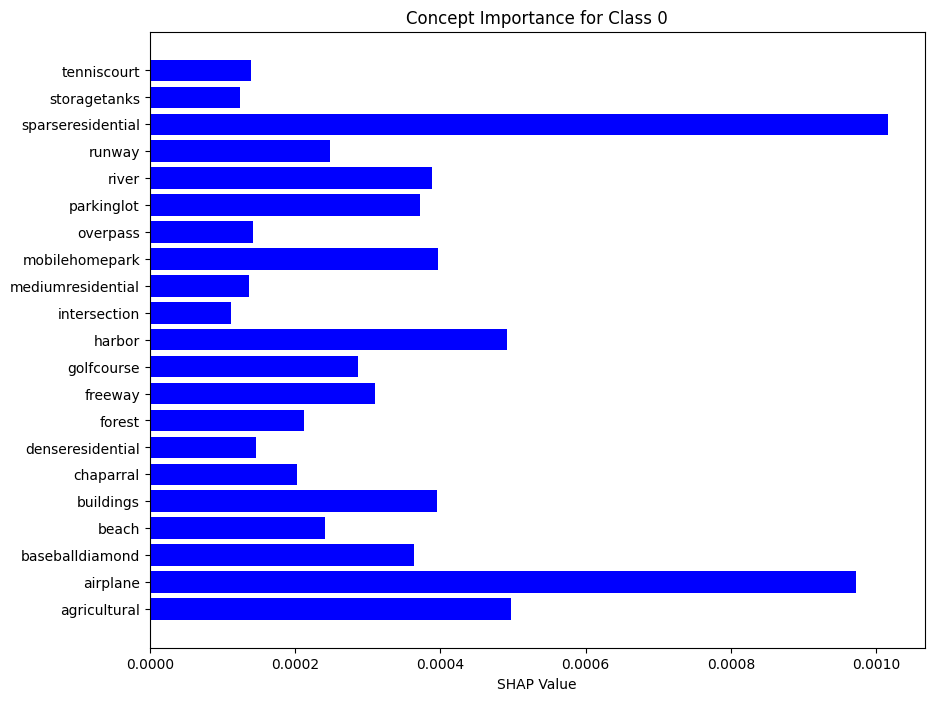

In [98]:
import numpy as np
import matplotlib.pyplot as plt
# Plot bar chart for Class 0 SHAP values with concept names
plt.figure(figsize=(10, 8))
plt.barh(concept_names, aggregated_shap_values[:, 0], color='blue')
plt.xlabel("SHAP Value")
plt.title("Concept Importance for Class 0")
plt.show()

## section below is the right one, but takes approx. 30 min

In [15]:
import numpy as np
import cv2
import os

# Function to preprocess and load images without limiting to a single batch
def load_and_preprocess_images(concepts_dir, target_size=(224, 224)):
    image_paths = []
    labels = []
    classes = sorted(os.listdir(concepts_dir))
    class_indices = {cls: cls for cls in classes}  # Use class names directly as labels

    # Print the identified classes (concept names)
    print(f"Identified classes (concepts): {classes}")

    # Traverse through directories and collect image paths and labels for all images
    for root, dirs, files in os.walk(concepts_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                class_name = os.path.basename(root)
                image_paths.append(os.path.join(root, file))
                labels.append(class_name)  # Use actual class names as labels

    print(f"Found {len(image_paths)} images in {concepts_dir}.")

    # Load and preprocess all images
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)

    images = np.array(images)
    return images, labels, image_paths

# Load and preprocess images from your concept dataset
concepts_dir = '/content/concepts/images_train_test_val/train'  # Adjust based on your folder structure
real_images, labels, image_paths = load_and_preprocess_images(concepts_dir)
print(len(real_images))

# Now real_images contains all images, not just one batch of 32

# Extract features and process them over batches as before
all_features = []
all_labels = []
batch_size = 32

# Calculate the number of batches based on the total number of images
num_batches = (len(real_images) + batch_size - 1) // batch_size

# Process all images in batches
for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, len(real_images))  # Ensure we don't exceed the total number of images

    # Get batch of images and labels
    batch_images = real_images[start:end]
    batch_labels = labels[start:end]

    # Extract features for the current batch
    batch_features = extract_features(intermediate_layer_model, batch_images)

    # Accumulate features and labels
    all_features.extend(batch_features)
    all_labels.extend(batch_labels)

# Convert accumulated features and labels to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Check the number of accumulated features and labels
print(f"Total number of accumulated features: {all_features.shape}")
print(f"Total number of accumulated labels: {all_labels.shape}")
print(f"Unique labels (classes) found: {np.unique(all_labels)}")

# Proceed with averaging the features by class, as in the previous steps
class_features = {}
for i, label in enumerate(all_labels):
    if label not in class_features:
        class_features[label] = []
    class_features[label].append(all_features[i])

# Compute the average feature vector for each class
average_concept_embeddings = {}
for label, feature_list in class_features.items():
    average_concept_embeddings[label] = np.mean(feature_list, axis=0)
    print(f"Class '{label}': Averaged feature vector shape: {average_concept_embeddings[label].shape}")


Identified classes (concepts): ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Found 7350 images in /content/concepts/images_train_test_val/train.
7350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [16]:
!pip install tcav


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 963.0 kB/s eta 0:00:00


In [17]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.4 MB/s eta 0:00:00


In [13]:
# Print the shape of the concept matrix
print("Shape of concept matrix:", concept_matrix.shape)


NameError: name 'concept_matrix' is not defined

In [39]:
model2_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 42,237,960 (161.13 MB)

 Trainable params: 9,193,858 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

 Optimizer params: 18,387,718 (70.14 MB)

In [14]:
for idx, input_layer in enumerate(model2_loaded.inputs):
    print(f"Input {idx} shape: {input_layer.shape}")


Input 0 shape: (None, 224, 224, 3)


In [18]:
# Define batch size
batch_size = 16  # Adjust based on memory constraints

# Placeholder for accumulated activations
all_image_activations = []

# Batch process to avoid memory issues
for i in range(0, len(real_images), batch_size):
    batch_images = real_images[i:i + batch_size]

    # Extract activations for this batch
    batch_activations = intermediate_layer_model.predict(batch_images)

    # Store the activations
    all_image_activations.append(batch_activations)
    print(f"Processed batch {i // batch_size + 1}/{len(real_images) // batch_size + 1}")

# Concatenate all activations into one array
all_image_activations = np.concatenate(all_image_activations, axis=0)

# Confirm the shape of the activations
print("Shape of all image activations:", all_image_activations.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processed batch 1/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed batch 2/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processed batch 3/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processed batch 4/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processed batch 5/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processed batch 6/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processed batch 7/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processed batch 8/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Processed batch 9/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processed batch 10/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processed batch 11/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed batch 12/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed batch 13/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processed batch 14/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed batch 15/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processed batch 16/460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

In [19]:
'''import shap ##### OLD OLD OLD OLD SECTION BELOW IS THE RIHT ONE

# Define the model for the remaining layers after the intermediate activations
remaining_layers_model = tf.keras.Model(inputs=intermediate_layer_model.output,
                                        outputs=model2_loaded.output)

# Define the function to pass activations through the remaining layers of the model
def predict_with_activations(activations):
    return remaining_layers_model.predict(activations)

# Reduce the background samples for SHAP to speed up the computation
background_sample = shap.sample(all_image_activations, 100)  # Use only 100 background samples

# Set up SHAP KernelExplainer with the reduced background
explainer = shap.KernelExplainer(predict_with_activations, background_sample)

print("SHAP explainer setup complete with reduced background samples.")
'''

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
SHAP explainer setup complete with reduced background samples.


In [20]:
import shap
import numpy as np
# Define the model for the remaining layers after the intermediate activations
remaining_layers_model = tf.keras.Model(inputs=intermediate_layer_model.output,
                                        outputs=model2_loaded.output)

# Define the function to pass activations through the remaining layers of the model
def predict_with_activations(activations):
    return remaining_layers_model.predict(activations)

# Reduce background sample for efficiency
background_sample = shap.sample(all_image_activations, 50)

# Set up SHAP KernelExplainer
explainer = shap.KernelExplainer(predict_with_activations, background_sample)

print("SHAP explainer setup complete with reduced background samples.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
SHAP explainer setup complete with reduced background samples.


##secodn try that does not take as long

In [22]:
# Ensure that intermediate layer activations have been extracted already
print("Shape of all image activations:", all_image_activations.shape)  # Should be something like (7350, 2048)


Shape of all image activations: (7350, 2048)


In [23]:
import numpy as np

# Ensure that we have all_labels and all_image_activations from previous steps
# all_labels should already have the labels for each activation (i.e., concepts like 'forest', 'beach', etc.)
print("Total number of accumulated labels:", len(all_labels))  # Check the total number of labels

# Extract unique labels from the accumulated labels
unique_labels = np.unique(all_labels)  # This will be the unique concept classes
print("Unique labels (concept classes):", unique_labels)


Total number of accumulated labels: 7350
Unique labels (concept classes): ['agricultural' 'airplane' 'baseballdiamond' 'beach' 'buildings'
 'chaparral' 'denseresidential' 'forest' 'freeway' 'golfcourse' 'harbor'
 'intersection' 'mediumresidential' 'mobilehomepark' 'overpass'
 'parkinglot' 'river' 'runway' 'sparseresidential' 'storagetanks'
 'tenniscourt']


In [24]:
import numpy as np

# Number of samples to take per concept
num_per_concept = 10  # Adjust this based on memory constraints and the diversity you want

# Placeholder to store sampled activations
sampled_activations = []

# Loop through each unique concept
for concept in unique_labels:
    # Find indices where the labels match the current concept
    concept_indices = np.where(all_labels == concept)[0]

    # Shuffle the indices to ensure randomness
    np.random.shuffle(concept_indices)

    # Take the first `num_per_concept` activations
    sampled_indices = concept_indices[:num_per_concept]

    # Append the sampled activations for the current concept
    sampled_activations.append(all_image_activations[sampled_indices])

# Combine the sampled activations from all concepts into a single array
sampled_activations = np.concatenate(sampled_activations, axis=0)

print("Shape of sampled activations:", sampled_activations.shape)


Shape of sampled activations: (210, 2048)


In [25]:
import shap

# Use DeepExplainer with the stratified sample
explainer = shap.DeepExplainer(remaining_layers_model, sampled_activations)

print("SHAP explainer setup complete.")


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


SHAP explainer setup complete.


In [28]:
import shap
import numpy as np

# Calculate SHAP values for the sampled activations
shap_values = explainer.shap_values(sampled_activations)

# Diagnostic print to check type and shape of shap_values
print(f"Type of shap_values: {type(shap_values)}")

if isinstance(shap_values, list):
    print(f"Length of shap_values list: {len(shap_values)}")
    for i, shap_value in enumerate(shap_values):
        print(f"Shape of shap_values[{i}]: {np.array(shap_value).shape}")
else:
    print(f"Shape of shap_values: {np.array(shap_values).shape}")


Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (210, 2048, 2)


In [29]:
# Diagnostic print to check the shape of sampled_activations
print(f"Shape of sampled_activations: {sampled_activations.shape}")


Shape of sampled_activations: (210, 2048)


Visualizing SHAP values for class 1


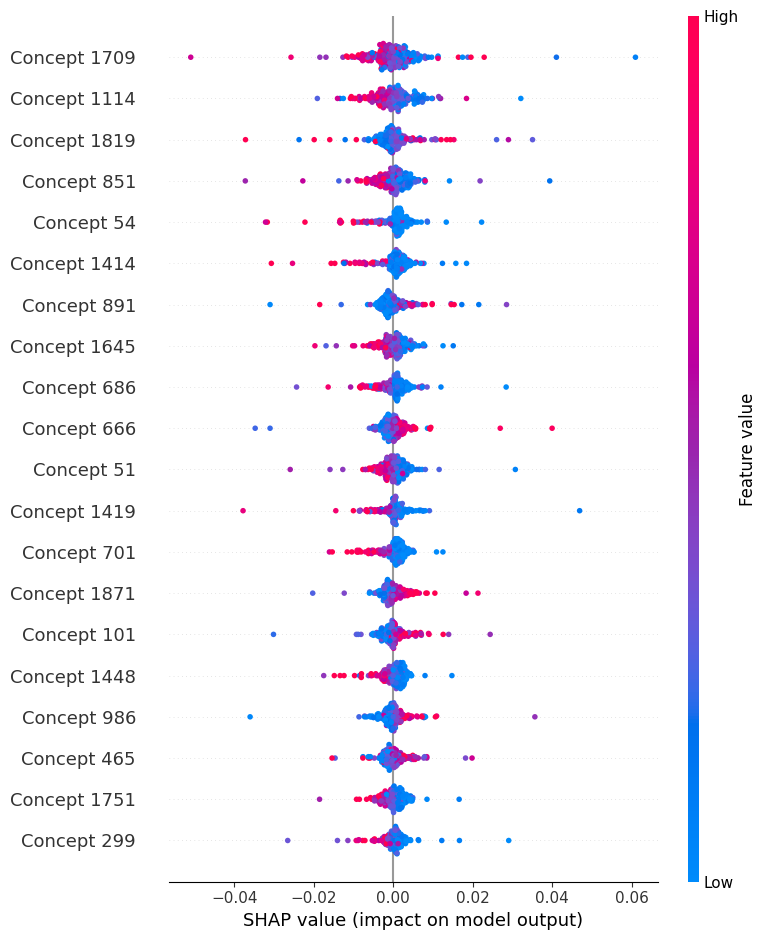

In [30]:
import shap

# For binary classification, visualize SHAP values for one class
# Choose class index 1 (positive class) or 0 (negative class) as needed
class_idx_to_visualize = 1  # Change to 0 if you want to visualize the negative class

# Extract SHAP values for the selected class
shap_values_class = shap_values[:, :, class_idx_to_visualize]

# Visualize SHAP values using summary plot
print(f"Visualizing SHAP values for class {class_idx_to_visualize}")
shap.summary_plot(shap_values_class, sampled_activations,
                  feature_names=["Concept " + str(i) for i in range(sampled_activations.shape[1])])


TypeError: only integer scalar arrays can be converted to a scalar index

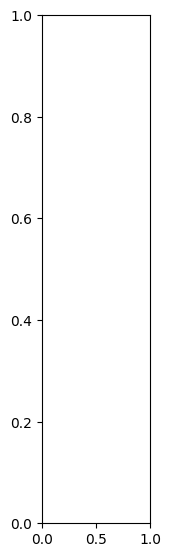

In [31]:
# Ensure you have the concept class names in correct order
concept_class_names = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
                       'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                       'harbor', 'intersection', 'mediumresidential', 'mobilehomepark',
                       'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                       'storagetanks', 'tenniscourt']

# Plot SHAP values using concept class names
shap.summary_plot(shap_values, sampled_activations, feature_names=concept_class_names)


In [32]:
# Print diagnostic information before plotting
print("Shape of shap_values:", shap_values.shape)
print("Shape of sampled_activations:", sampled_activations.shape)
print("Number of concept class names:", len(concept_class_names))


Shape of shap_values: (210, 2048, 2)
Shape of sampled_activations: (210, 2048)
Number of concept class names: 21


## Start over with stratified samiling

In [35]:
import numpy as np

# Number of samples to take per concept
num_per_concept = 10  # Adjust this based on memory constraints and the diversity you want

# Placeholder to store sampled activations and corresponding labels
sampled_activations = []
sampled_labels = []

# Loop through each unique concept
for concept in unique_labels:
    # Find indices where the labels match the current concept
    concept_indices = np.where(np.array(all_labels) == concept)[0]

    # Diagnostic print: Check the number of available indices for this concept
    print(f"Concept '{concept}' has {len(concept_indices)} samples available.")

    # Shuffle the indices to ensure randomness
    np.random.shuffle(concept_indices)

    # Take the first `num_per_concept` activations
    sampled_indices = concept_indices[:num_per_concept]

    # Append the sampled activations and labels for the current concept
    sampled_activations.append(all_image_activations[sampled_indices])
    sampled_labels.extend([concept] * len(sampled_indices))  # Repeat the concept label

    # Diagnostic print: Check shapes after each concept is processed
    print(f"Sampled activations shape so far: {np.array(sampled_activations).shape}")
    print(f"Sampled labels count so far: {len(sampled_labels)}")


# Combine the sampled activations from all concepts into a single array
sampled_activations = np.concatenate(sampled_activations, axis=0)

# Convert sampled_labels to a numpy array for consistency
sampled_labels = np.array(sampled_labels)

# Final diagnostic print: Ensure everything looks correct
print("Final shape of sampled activations:", sampled_activations.shape)
print("Final count of sampled labels:", len(sampled_labels))
print("Unique sampled labels:", np.unique(sampled_labels))


Concept 'agricultural' has 350 samples available.
Sampled activations shape so far: (1, 10, 2048)
Sampled labels count so far: 10
Concept 'airplane' has 350 samples available.
Sampled activations shape so far: (2, 10, 2048)
Sampled labels count so far: 20
Concept 'baseballdiamond' has 350 samples available.
Sampled activations shape so far: (3, 10, 2048)
Sampled labels count so far: 30
Concept 'beach' has 350 samples available.
Sampled activations shape so far: (4, 10, 2048)
Sampled labels count so far: 40
Concept 'buildings' has 350 samples available.
Sampled activations shape so far: (5, 10, 2048)
Sampled labels count so far: 50
Concept 'chaparral' has 350 samples available.
Sampled activations shape so far: (6, 10, 2048)
Sampled labels count so far: 60
Concept 'denseresidential' has 350 samples available.
Sampled activations shape so far: (7, 10, 2048)
Sampled labels count so far: 70
Concept 'forest' has 350 samples available.
Sampled activations shape so far: (8, 10, 2048)
Sampled 

In [36]:
# Function to count images per class (concept)
def count_images_per_class(concepts_dir):
    class_counts = {}

    # Loop through the directories for each concept class
    for root, dirs, files in os.walk(concepts_dir):
        if len(files) > 0:  # Ensure this is a directory with files
            class_name = os.path.basename(root)  # Get the class name from the directory
            num_images = len([file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = num_images

    return class_counts

# Get the image count per class
image_counts = count_images_per_class(concepts_dir)

# Print the results
for class_name, count in image_counts.items():
    print(f"Class '{class_name}' has {count} images.")

Class 'sparseresidential' has 350 images.
Class 'beach' has 350 images.
Class 'overpass' has 350 images.
Class 'intersection' has 350 images.
Class 'baseballdiamond' has 350 images.
Class 'storagetanks' has 350 images.
Class 'harbor' has 350 images.
Class 'golfcourse' has 350 images.
Class 'agricultural' has 350 images.
Class 'tenniscourt' has 350 images.
Class 'chaparral' has 350 images.
Class 'buildings' has 350 images.
Class 'forest' has 350 images.
Class 'airplane' has 350 images.
Class 'runway' has 350 images.
Class 'mobilehomepark' has 350 images.
Class 'parkinglot' has 350 images.
Class 'freeway' has 350 images.
Class 'mediumresidential' has 350 images.
Class 'denseresidential' has 350 images.
Class 'river' has 350 images.


In [37]:
import numpy as np

# Step 1: Average activations by concept class
def average_activations_by_class(labels, activations, unique_labels):
    class_activations = {label: [] for label in unique_labels}

    # Loop through each label and append the corresponding activation
    for i, label in enumerate(labels):
        class_activations[label].append(activations[i])

    # Compute the average activation for each class
    averaged_activations = []
    for label in unique_labels:
        # Average the activations for the current class
        averaged_activations.append(np.mean(class_activations[label], axis=0))

    return np.array(averaged_activations)

# Average activations across concept classes
unique_labels = sorted(list(set(sampled_labels)))  # Ensure consistent order of labels
averaged_concept_activations = average_activations_by_class(sampled_labels, sampled_activations, unique_labels)

print("Averaged concept activations shape:", averaged_concept_activations.shape)
print("Unique concept labels:", unique_labels)


Averaged concept activations shape: (21, 2048)
Unique concept labels: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [39]:
# Debugging: Print the shapes to confirm they match
print("Shape of SHAP values:", [np.array(shap_val).shape for shap_val in shap_values])
print("Shape of averaged concept activations:", averaged_concept_activations.shape)
print("Number of concept labels (unique_labels):", len(unique_labels))

Shape of SHAP values: [(2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2)]
Shape of averaged concept activations: (21, 2048)
Number of concept labels (unique_labels): 21


In [40]:
# Initialize DeepSHAP explainer
explainer = shap.DeepExplainer(remaining_layers_model, averaged_concept_activations)

# Compute SHAP values for the concept embeddings
shap_values = explainer.shap_values(averaged_concept_activations)

# Check the shape of the resulting SHAP values
print("Shape of SHAP values:", [shap_val.shape for shap_val in shap_values])


Shape of SHAP values: [(2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2)]


In [46]:
# Print the shape of averaged concept activations
print("Averaged concept activations shape:", averaged_concept_activations.shape)

# Check the shape should be (num_concepts, feature_size)
expected_shape = (len(unique_labels), 2048)  # Replace feature_size with the correct value
print("Expected shape:", expected_shape)
assert averaged_concept_activations.shape == expected_shape, "Shape mismatch!"


Averaged concept activations shape: (21, 2048)
Expected shape: (21, 2048)


In [64]:
print("Sample of averaged_concept_activations:")
print(averaged_concept_activations[:5])  # Print the first 5 samples or rows


Sample of averaged_concept_activations:
[[0.17388092 0.2899312  0.37741825 ... 0.866751   0.09988324 0.08720384]
 [0.15403177 0.22223273 0.36621955 ... 1.0886527  0.08147843 0.08949862]
 [0.14690691 0.15628183 0.40008917 ... 1.0072719  0.08302191 0.09030805]
 [0.14789884 0.14271078 0.27803338 ... 0.9754839  0.06315081 0.07759552]
 [0.14556812 0.17737404 0.38879973 ... 1.3278575  0.10130315 0.11034427]]


In [47]:
# Compute SHAP values for the concept embeddings
shap_values = explainer.shap_values(averaged_concept_activations)

# Print shapes of SHAP values
print("Shape of SHAP values:")
for i, shap_val in enumerate(shap_values):
    print(f"Output {i}: {shap_val.shape}")


Shape of SHAP values:
Output 0: (2048, 2)
Output 1: (2048, 2)
Output 2: (2048, 2)
Output 3: (2048, 2)
Output 4: (2048, 2)
Output 5: (2048, 2)
Output 6: (2048, 2)
Output 7: (2048, 2)
Output 8: (2048, 2)
Output 9: (2048, 2)
Output 10: (2048, 2)
Output 11: (2048, 2)
Output 12: (2048, 2)
Output 13: (2048, 2)
Output 14: (2048, 2)
Output 15: (2048, 2)
Output 16: (2048, 2)
Output 17: (2048, 2)
Output 18: (2048, 2)
Output 19: (2048, 2)
Output 20: (2048, 2)


In [52]:
# Diagnostic print to verify the number of SHAP values per class
print(f"Number of SHAP values per class: {len(shap_values)}")
print(f"Shape of SHAP values for first class: {shap_values[0].shape}")
print(f"Shape of SHAP values for second class: {shap_values[1].shape}")


Number of SHAP values per class: 21
Shape of SHAP values for first class: (2048, 2)
Shape of SHAP values for second class: (2048, 2)


In [53]:
print(len(shap_values))  # Number of concepts
print(shap_values[0].shape[0])  # Number of features (2048)
print(shap_values[0].shape[1])

21
2048
2


In [63]:
print(shap_values[0])

[[-2.15961016e-04  2.15961016e-04]
 [-9.46527999e-03  9.46527999e-03]
 [ 1.34970748e-03 -1.34970748e-03]
 ...
 [-1.27967552e-03  1.27967552e-03]
 [ 8.62104935e-05 -8.62104935e-05]
 [-8.96906058e-05  8.96906058e-05]]


In [61]:
import numpy as np

def aggregate_shap_values_across_features(shap_values):
    num_concepts = len(shap_values)  # Number of concepts
    num_features = shap_values[0].shape[0]  # Number of features (2048)
    num_classes = shap_values[0].shape[1]  # Number of classes (2)

    # Initialize array to hold aggregated SHAP values for each concept and class
    aggregated_shap_values_per_concept = np.zeros((num_concepts, num_classes))

    for concept_index in range(num_concepts):
        # Get SHAP values for the current concept
        concept_shap_values = shap_values[concept_index]

        # Compute mean absolute SHAP values across features for each class
        for class_index in range(num_classes):
            aggregated_shap_values_per_concept[concept_index, class_index] = np.mean(np.abs(concept_shap_values[:, class_index]))

        # Diagnostic print statements
        print(f"Concept {concept_index} SHAP values shape: {concept_shap_values.shape}")
        print(f"Aggregated SHAP values for concept {concept_index}: {aggregated_shap_values_per_concept[concept_index]}")

    return aggregated_shap_values_per_concept

# Example usage
aggregated_shap_values_per_concept = aggregate_shap_values_across_features(shap_values)


Concept 0 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 0: [0.00364378 0.00364378]
Concept 1 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 1: [0.00032432 0.00032432]
Concept 2 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 2: [0.00356387 0.00356387]
Concept 3 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 3: [0.0003715 0.0003715]
Concept 4 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 4: [0.0065305 0.0065305]
Concept 5 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 5: [0.00031295 0.00031295]
Concept 6 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 6: [0.0002129 0.0002129]
Concept 7 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 7: [0.00034354 0.00034354]
Concept 8 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 8: [0.00020997 0.00020997]
Concept 9 SHAP values shape: (2048, 2)
Aggregated SHAP values for concept 9: [0.00034604 0.000346

In [62]:
import numpy as np

def aggregate_shap_values_across_features(shap_values):
    num_concepts = len(shap_values)  # Number of concepts
    num_features = shap_values[0].shape[0]  # Number of features (2048)
    num_classes = shap_values[0].shape[1]  # Number of classes (2)

    # Initialize array to hold aggregated SHAP values for each concept and class
    aggregated_shap_values_per_concept = np.zeros((num_concepts, num_classes))

    for concept_index in range(num_concepts):
        # Get SHAP values for the current concept
        concept_shap_values = shap_values[concept_index]

        # Print the concept SHAP values
        print(f"Concept {concept_index} SHAP values:\n{concept_shap_values}")

        # Compute mean absolute SHAP values across features for each class
        for class_index in range(num_classes):
            mean_absolute_shap = np.mean(np.abs(concept_shap_values[:, class_index]))
            aggregated_shap_values_per_concept[concept_index, class_index] = mean_absolute_shap

            # Print intermediate mean absolute SHAP values
            print(f"Class {class_index} mean absolute SHAP for concept {concept_index}: {mean_absolute_shap}")

    # Print the aggregated SHAP values for all concepts
    print(f"Aggregated SHAP values per concept:\n{aggregated_shap_values_per_concept}")

    return aggregated_shap_values_per_concept

# Example usage
aggregated_shap_values_per_concept = aggregate_shap_values_across_features(shap_values)


Concept 0 SHAP values:
[[-2.15961016e-04  2.15961016e-04]
 [-9.46527999e-03  9.46527999e-03]
 [ 1.34970748e-03 -1.34970748e-03]
 ...
 [-1.27967552e-03  1.27967552e-03]
 [ 8.62104935e-05 -8.62104935e-05]
 [-8.96906058e-05  8.96906058e-05]]
Class 0 mean absolute SHAP for concept 0: 0.003643783167782688
Class 1 mean absolute SHAP for concept 0: 0.003643783167782688
Concept 1 SHAP values:
[[-1.90761100e-04  1.90761100e-04]
 [-5.23785202e-05  5.23785202e-05]
 [-3.25292604e-05  3.25292604e-05]
 ...
 [-4.50735155e-04  4.50735155e-04]
 [-1.78645387e-05  1.78645387e-05]
 [-1.17909396e-04  1.17909396e-04]]
Class 0 mean absolute SHAP for concept 1: 0.00032432087923738723
Class 1 mean absolute SHAP for concept 1: 0.00032432087923738723
Concept 2 SHAP values:
[[ 2.12338680e-04 -2.12338680e-04]
 [ 9.06493422e-03 -9.06493422e-03]
 [-1.50379143e-03  1.50379143e-03]
 ...
 [ 7.26018567e-04 -7.26018567e-04]
 [-9.38801095e-05  9.38801095e-05]
 [-5.49227989e-05  5.49227989e-05]]
Class 0 mean absolute SHAP 

In [56]:
def aggregate_shap_values_across_concepts(aggregated_shap_values_per_concept):
    num_concepts = aggregated_shap_values_per_concept.shape[0]  # Number of concepts
    print(num_concepts)
    num_classes = aggregated_shap_values_per_concept.shape[1]  # Number of classes (2)
    print(num_classes)

    # Compute mean SHAP values across concepts for each class
    aggregated_shap_values_per_class = np.mean(aggregated_shap_values_per_concept, axis=0)

    return aggregated_shap_values_per_class
    print(aggregated_shap_values_per_class.shape)


In [58]:
import matplotlib.pyplot as plt

def plot_aggregated_shap_values_per_class(aggregated_shap_values_per_class):
    num_concepts = aggregated_shap_values_per_class.shape[0]  # Number of concepts
    num_classes = aggregated_shap_values_per_class.shape[1]  # Number of classes

    x = np.arange(num_concepts)  # Concept indices

    fig, ax = plt.subplots()

    for class_index in range(num_classes):
        ax.plot(x, aggregated_shap_values_per_class[:, class_index], label=f'Class {class_index}')

    ax.set_xlabel('Concepts')
    ax.set_ylabel('Mean Absolute SHAP Value')
    ax.set_title('Aggregated SHAP Values by Concept for Each Class')
    ax.legend()

    plt.tight_layout()
    plt.show()


In [59]:
# Compute aggregated SHAP values across features
aggregated_shap_values_per_concept = aggregate_shap_values_across_features(shap_values)

# Compute aggregated SHAP values across concepts
aggregated_shap_values_per_class = aggregate_shap_values_across_concepts(aggregated_shap_values_per_concept)

# Plot aggregated SHAP values per class
plot_aggregated_shap_values_per_class(aggregated_shap_values_per_class)


21
2


IndexError: tuple index out of range

In [54]:
import numpy as np

def aggregate_shap_values(shap_values):
    num_concepts = len(shap_values)  # Number of concepts
    num_features = shap_values[0].shape[0]  # Number of features (2048)
    num_classes = shap_values[0].shape[1]  # Number of classes (2)

    # Initialize arrays to hold aggregated SHAP values for each class
    aggregated_shap_values = {cls: np.zeros((num_features,)) for cls in range(num_classes)}

    for concept_index in range(num_concepts):
        # Get SHAP values for the current concept
        concept_shap_values = shap_values[concept_index]

        # Aggregate SHAP values for each class (mean across features)
        for class_index in range(num_classes):
            aggregated_shap_values[class_index] += np.mean(np.abs(concept_shap_values[:, class_index]), axis=0)

        # Diagnostic print for each concept
        print(f"Aggregated SHAP values for concept {concept_index}:")
        for class_index in range(num_classes):
            print(f"  Class {class_index} shape: {aggregated_shap_values[class_index].shape}")

    # Normalize by the number of concepts to get the average per concept
    for class_index in range(num_classes):
        aggregated_shap_values[class_index] /= num_concepts

    return aggregated_shap_values

# Compute aggregated SHAP values
aggregated_shap_values = aggregate_shap_values(shap_values)

# Print results for diagnostic purposes
for class_index, shap_val in aggregated_shap_values.items():
    print(f"Aggregated SHAP values for class {class_index}: {shap_val.shape}")


Aggregated SHAP values for concept 0:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 1:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 2:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 3:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 4:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 5:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 6:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 7:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 8:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 9:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for concept 10:
  Class 0 shape: (2048,)
  Class 1 shape: (2048,)
Aggregated SHAP values for conc

In [42]:
# Re-initialize DeepExplainer
explainer = shap.DeepExplainer(remaining_layers_model, averaged_concept_activations)

# Compute SHAP values for the averaged concept embeddings
shap_values = explainer.shap_values(averaged_concept_activations)

# Check the shape of the SHAP values for debugging purposes
print("Shape of SHAP values:", [shap_val.shape for shap_val in shap_values])
print("Averaged concept activations shape:", averaged_concept_activations.shape)


Shape of SHAP values: [(2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2), (2048, 2)]
Averaged concept activations shape: (21, 2048)


In [44]:
# Print summaries for both the intermediate and remaining layer models
print("Intermediate Layer Model Summary:")
intermediate_layer_model.summary()

print("\nRemaining Layers Model Summary:")
remaining_layers_model.summary()


Intermediate Layer Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 8,931,328 (34.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)


Remaining Layers Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_365CLONE (InputLayer)   │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,530 (1.00 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

TypeError: only integer scalar arrays can be converted to a scalar index

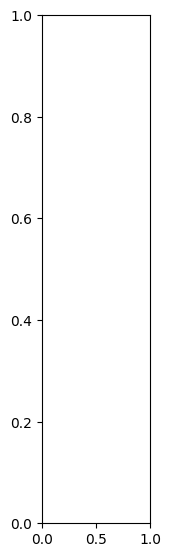

In [38]:
import shap
import numpy as np

# Assuming `averaged_concept_activations` and `remaining_layers_model` are already defined

# Step 1: Prepare the background data for DeepSHAP
# We will use the averaged concept activations as a baseline (background).
background_data = averaged_concept_activations

# Step 2: Initialize the DeepSHAP explainer
explainer = shap.DeepExplainer(remaining_layers_model, background_data)

# Step 3: Compute SHAP values
# Since we're interested in the global explanation, we apply the explainer to the averaged activations
shap_values = explainer.shap_values(averaged_concept_activations)

# Step 4: Visualize the SHAP values
# Here, we directly visualize how each concept contributes to the final prediction globally
shap.summary_plot(shap_values, averaged_concept_activations, feature_names=unique_labels)


## start over again

## other

In [34]:
import numpy as np

# Step 1: Average activations by concept class
def average_activations_by_class(labels, activations, unique_labels):
    class_activations = {label: [] for label in unique_labels}

    print(f"Number of labels: {len(labels)}")
    print(f"Number of activations: {len(activations)}")
    for i, label in enumerate(labels):
        class_activations[label].append(activations[i])

    averaged_activations = []
    for label in unique_labels:
        averaged_activations.append(np.mean(class_activations[label], axis=0))

    return np.array(averaged_activations)

# Average activations across concept classes
unique_labels = sorted(list(set(labels)))  # Ensure consistent order
averaged_concept_activations = average_activations_by_class(labels, sampled_activations, unique_labels)


print("Averaged concept activations shape:", averaged_concept_activations.shape)


Number of labels: 7350
Number of activations: 210


IndexError: index 210 is out of bounds for axis 0 with size 210

In [ ]:
# Step 2: Use DeepExplainer instead of KernelExplainer
explainer = shap.DeepExplainer(remaining_layers_model, averaged_concept_activations)

# Step 3: Get SHAP values for the first sample's concept activations
shap_values = explainer.shap_values(averaged_concept_activations)

# Step 4: Visualize the SHAP values with concept names
concept_class_names = unique_labels  # These should be the names of your concepts (e.g., 'forest', 'water', etc.)

print("Shape of recalculated shap_values:", np.array(shap_values).shape)
shap.summary_plot(shap_values, averaged_concept_activations, feature_names=concept_class_names)


TypeError: only integer scalar arrays can be converted to a scalar index

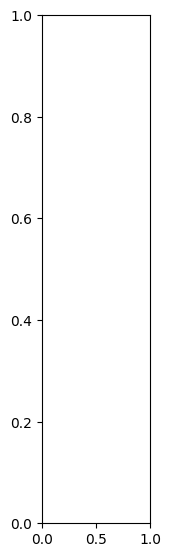

In [27]:
import shap

# Calculate SHAP values for the sampled activations
shap_values = explainer.shap_values(sampled_activations)

# Check if shap_values is a list (which it will be for multi-class models)
if isinstance(shap_values, list):
    # Choose which class to visualize (e.g., the first class, index 0)
    class_idx_to_visualize = 0
    shap_values_class = shap_values[class_idx_to_visualize]

    print(f"Visualizing SHAP values for class {class_idx_to_visualize}")

    # Visualize SHAP values for the chosen class
    shap.summary_plot(shap_values_class, sampled_activations,
                      feature_names=["Concept " + str(i) for i in range(sampled_activations.shape[1])])
else:
    # For binary classification, shap_values will not be a list
    shap.summary_plot(shap_values, sampled_activations,
                      feature_names=["Concept " + str(i) for i in range(sampled_activations.shape[1])])


In [21]:
'''CODE TAKES 73h
# Define batch size for SHAP calculation
batch_size = 10  # Adjust this based on memory constraints

# Placeholder to accumulate SHAP values
global_shap_values = None

# Process SHAP values in batches
for i in range(0, len(all_image_activations), batch_size):
    # Select a batch of activations
    batch_activations = all_image_activations[i:i + batch_size]

    # Calculate SHAP values for the current batch
    batch_shap_values = explainer.shap_values(batch_activations)

    # Accumulate the SHAP values (sum them up)
    if global_shap_values is None:
        global_shap_values = np.array(batch_shap_values)
    else:
        global_shap_values += np.array(batch_shap_values)

    print(f"Processed SHAP values for batch {i // batch_size + 1}/{len(all_image_activations) // batch_size + 1}")

# Average the SHAP values across all batches for a global view
global_shap_values /= len(all_image_activations)

# Visualize global SHAP values
shap.summary_plot(global_shap_values, all_image_activations, feature_names=["Concept " + str(j) for j in range(all_image_activations.shape[1])])
'''

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Processed SHAP values for batch 1/736


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Processed SHAP values for batch 2/736


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Processed SHAP values for batch 3/736


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9600/9600 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1760/9600 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

KeyboardInterrupt: 

code below caused crash. Batch processing alternative above

In [ ]:
# Select a sample activation to explain (e.g., the first activation)
sample_activation = all_image_activations[0].reshape(1, -1)  # Reshape to match expected input

# Calculate SHAP values for the selected sample
shap_values = explainer.shap_values(sample_activation)

# Visualize SHAP values
shap.summary_plot(shap_values, all_image_activations, feature_names=["Concept " + str(i) for i in range(all_image_activations.shape[1])])


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


## session below led to crashing, session above to tr next

In [ ]:
import numpy as np
import shap

# Assuming `intermediate_layer_model` is the model that outputs the layer where you extracted concept embeddings
# `real_images` are the test images that you want to explain

# Step 1: Extract the intermediate layer activations for the test images
image_activations = intermediate_layer_model.predict(real_images)
print("Shape of image activations:", image_activations.shape)  # Should be (num_samples, 2048)

# Step 2: Define a simplified prediction function that uses the intermediate activations
def predict_with_activations(activations):
    # Pass the activations into the next layers of the original model for final predictions
    return model2_loaded.predict(activations)

# Step 3: Use SHAP's KernelExplainer on the activations
explainer = shap.KernelExplainer(predict_with_activations, image_activations)

# Step 4: Select a sample image activation to explain
sample_activation = image_activations[0]  # Example with first test image
shap_values = explainer.shap_values(sample_activation)

# Step 5: Visualize SHAP values
shap.summary_plot(shap_values, image_activations)


## old

In [22]:
import numpy as np

# Function to compute the average embeddings by class over multiple batches
def compute_average_embeddings_by_class(labels, extracted_features):
    # Get the unique classes (e.g., 'forest', 'urban', etc.)
    unique_labels = np.unique(labels)
    class_embeddings = {label: [] for label in unique_labels}

     # Print all unique labels identified
    print(f"Unique labels (concept classes) found: {unique_labels}")

    # Group embeddings by class label
    for i, label in enumerate(labels):
        class_embeddings[label].append(extracted_features[i])

    # Compute the average embedding for each class
    averaged_embeddings = {}
    for label, embeddings in class_embeddings.items():
        averaged_embeddings[label] = np.mean(embeddings, axis=0)  # Average the embeddings per class

    return averaged_embeddings

# Accumulate all features and labels over multiple batches
all_features = []
all_labels = []

# Check the number of images
if len(real_images) == 0:
    raise ValueError("No images found in the dataset.")

# Set the batch size for processing
batch_size = 32
num_batches = (len(real_images) + batch_size - 1) // batch_size  # Correct way to calculate total number of batches

# Process the images in batches
for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, len(real_images))  # Ensure we don't exceed array length

    # Safeguard: Check if the batch_images is empty or improperly sized
    if end <= start:
        print(f"Skipping empty batch at index {i}.")
        continue

    batch_images = real_images[start:end]  # Select batch of images
    batch_labels = labels[start:end]  # Select corresponding labels for the batch

    # Extract features from the batch
    batch_features = extract_features(intermediate_layer_model, batch_images)

    # Accumulate the features and labels
    all_features.extend(batch_features)
    all_labels.extend(batch_labels)

# Convert accumulated features and labels to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Compute the average embeddings for each concept class
average_concept_embeddings = compute_average_embeddings_by_class(all_labels, all_features)

# Display the averaged concept embeddings
for label, avg_embedding in average_concept_embeddings.items():
    print(f"Concept class {label}: Averaged feature vector shape: {avg_embedding.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Unique labels (concept classes) found: [18]
Concept class 18: Averaged feature vector shape: (2048,)


In [25]:
print(len(real_images))

32


In [24]:
import numpy as np

# Accumulate all features and labels over multiple batches
all_features = []
all_labels = []
batch_size = 32  # Adjust batch size as needed

# Calculate the number of batches
num_batches = (len(real_images) + batch_size - 1) // batch_size

# Diagnostic: Print the number of batches
print(f"Number of batches to process: {num_batches}")

# Process all images in batches
for i in range(num_batches):
    start = i * batch_size
    end = min(start + batch_size, len(real_images))  # Ensure we don't exceed the total number of images

    # Diagnostic: Print batch info
    print(f"Processing batch {i+1}/{num_batches} - images {start} to {end}")

    # Get batch of images and labels
    batch_images = real_images[start:end]
    batch_labels = labels[start:end]

    # Extract features for the current batch
    batch_features = extract_features(intermediate_layer_model, batch_images)

    # Diagnostic: Print feature shape for current batch
    print(f"Batch {i+1}: Extracted feature shape: {batch_features.shape}")

    # Accumulate features and labels
    all_features.extend(batch_features)
    all_labels.extend(batch_labels)

# Convert accumulated features and labels to numpy arrays
all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Diagnostic: Print total features and labels info
print(f"Total number of accumulated features: {all_features.shape}")
print(f"Total number of accumulated labels: {all_labels.shape}")

# Step 1: Create a dictionary to store features for each class
class_features = {}
for i, label in enumerate(all_labels):
    if label not in class_features:
        class_features[label] = []
    class_features[label].append(all_features[i])

# Diagnostic: Print number of classes detected
print(f"Number of unique classes found: {len(class_features)}")

# Step 2: Compute the average feature vector for each class
average_concept_embeddings = {}
for label, feature_list in class_features.items():
    average_concept_embeddings[label] = np.mean(feature_list, axis=0)
    # Diagnostic: Print the number of embeddings used for each class
    print(f"Class '{label}': Number of embeddings used for averaging: {len(feature_list)}")

# Step 3: Display the averaged concept embeddings
for label, avg_embedding in average_concept_embeddings.items():
    print(f"Concept class '{label}': Averaged feature vector shape: {avg_embedding.shape}")


Number of batches to process: 1
Processing batch 1/1 - images 0 to 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Batch 1: Extracted feature shape: (32, 2048)
Total number of accumulated features: (32, 2048)
Total number of accumulated labels: (32,)
Number of unique classes found: 1
Class '18': Number of embeddings used for averaging: 32
Concept class '18': Averaged feature vector shape: (2048,)
